In [12]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
xgb_clf = joblib.load("../outputs/models/xgb_model.pkl")
label_encoder = joblib.load("../outputs/models/label_encoder.pkl")
X_train = joblib.load("../data/processed/X_train.pkl")
X_test = joblib.load("../data/processed/X_test.pkl")
y_test = joblib.load("../data/processed/y_test.pkl")

In [14]:
# STEP 2: CONVERT ALL FEATURES TO FLOATS (REQUIRED BY SHAP)
X_train_clean = X_train.copy().astype(float)
X_test_clean = X_test.copy().astype(float)

In [15]:
# STEP 3: INSTANTIATE SHAP EXPLAINER WITH FEATURE NAMES
explainer = shap.Explainer(
    xgb_clf,
    X_train_clean,
    feature_names=X_train_clean.columns.tolist()
)

In [17]:
#  STEP 4: COMPUTE SHAP VALUES
shap_values = explainer(X_test_clean)



100%|===================| 8099/8136 [01:53<00:00]        

In [18]:
# Identify which index corresponds to each class label
class_names = label_encoder.classes_
print("Class indices:", list(enumerate(class_names)))


Class indices: [(0, 'debtor'), (1, 'saver'), (2, 'spender')]


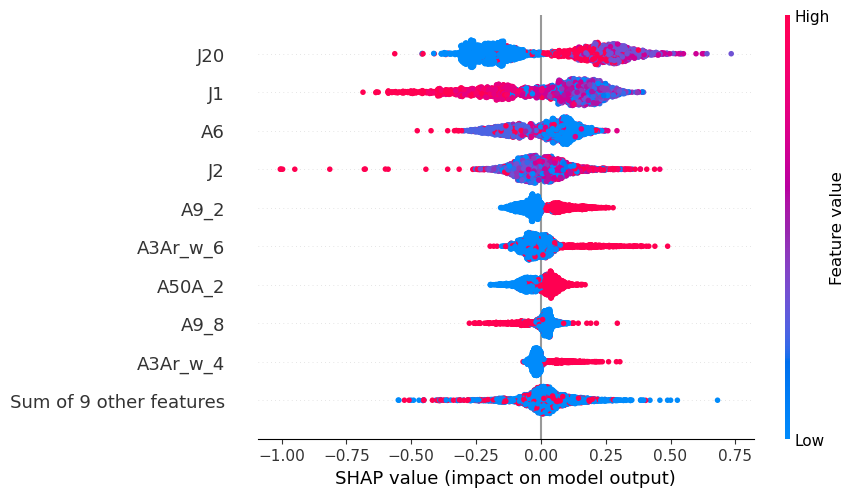

In [19]:
# Example: Beeswarm for class "saver" (index 1)
shap.plots.beeswarm(shap_values[:, :, 1], show=True)


SHAP Beeswarm for class: debtor


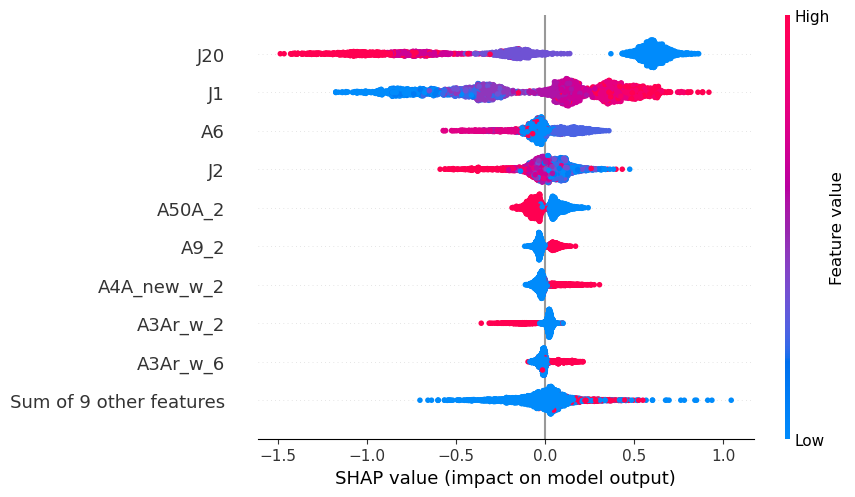

SHAP Beeswarm for class: saver


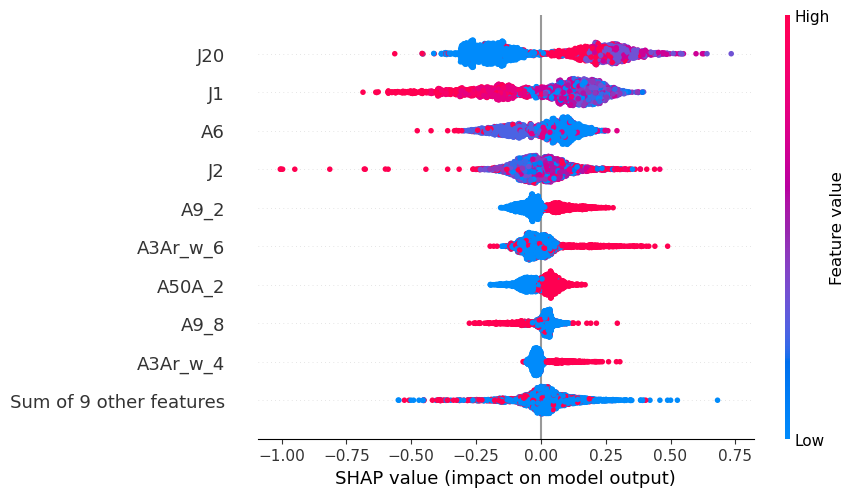

SHAP Beeswarm for class: spender


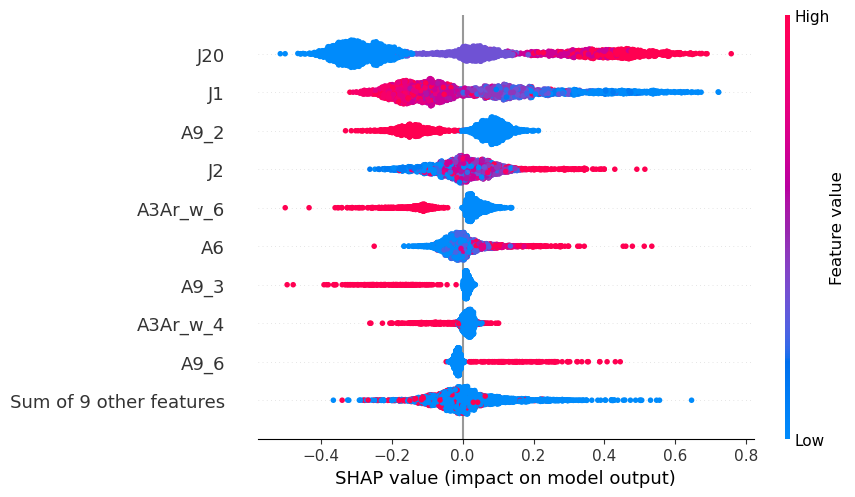

In [20]:
for i, name in enumerate(class_names):
    print(f"SHAP Beeswarm for class: {name}")
    shap.plots.beeswarm(shap_values[:, :, i], show=True)


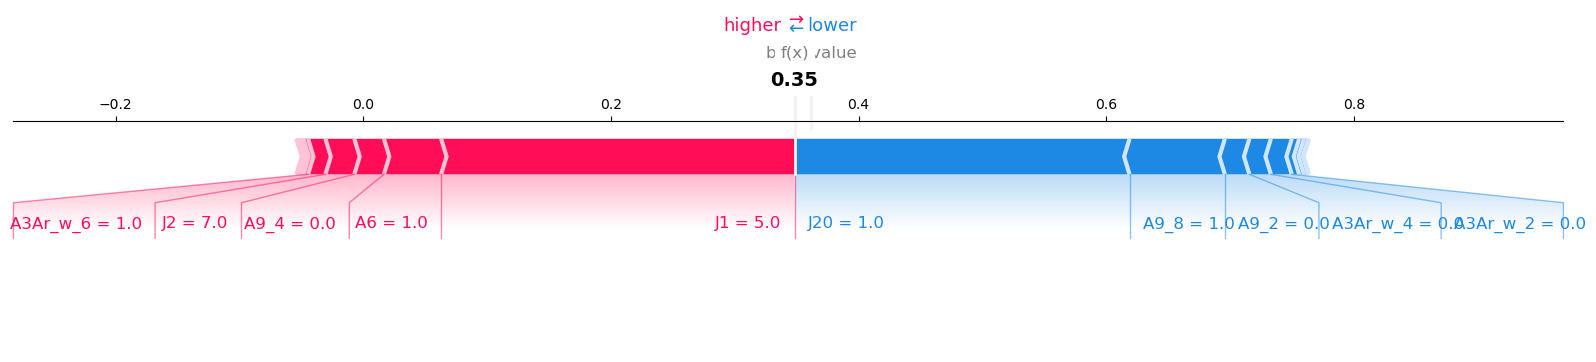

In [22]:
# Step 1: Get the *position* (not label) of a test instance with class "saver"
saver_pos = y_test_clean.reset_index(drop=True)[y_test_clean.reset_index(drop=True) == "saver"].index[0]

# Step 2: Get class index for "saver"
saver_class_index = list(label_encoder.classes_).index("saver")

# Step 3: Force plot
shap.plots.force(shap_values[saver_pos, :, saver_class_index], matplotlib=True)


In [39]:
import os

# Ensure 'plots' folder exists relative to current working dir
os.makedirs("plots", exist_ok=True)

for target_class in ["spender", "saver", "debtor"]:
    class_index = class_names.index(target_class)

    shap.plots.beeswarm(shap_values[:, class_index], show=False)
    plt.title(f"SHAP Summary for Class: {target_class.capitalize()}")
    plt.tight_layout()

    # Save and confirm full path
    save_path = f"plots/shap_summary_{target_class}.png"
    print("Saving to:", os.path.abspath(save_path))
    plt.savefig(save_path, bbox_inches="tight")
    plt.close()

    print(f"✅ Saved: {save_path}")


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Saving to: /Users/varunvenkatagiri/Documents/ml-stimulus-study/notebooks/plots/shap_summary_spender.png
✅ Saved: plots/shap_summary_spender.png
Saving to: /Users/varunvenkatagiri/Documents/ml-stimulus-study/notebooks/plots/shap_summary_saver.png
✅ Saved: plots/shap_summary_saver.png
Saving to: /Users/varunvenkatagiri/Documents/ml-stimulus-study/notebooks/plots/shap_summary_debtor.png
✅ Saved: plots/shap_summary_debtor.png


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure folder exists
os.makedirs("plots/interpretation", exist_ok=True)

# Mapping from feature codes to readable names
name_map = {
    "A6": "Income Volatility",
    "J1": "Job/Income Shock",
    "J2": "Emergency Savings",
    "J20": "Financial Fragility",
    "A3Ar_w_2": "HS or Less",
    "A3Ar_w_3": "Some College",
    "A3Ar_w_4": "Bachelor’s",
    "A3Ar_w_5": "Graduate Degree",
    "A3Ar_w_6": "Postgrad",
    "A50A_2": "Retirement Savings",
    "A4A_new_w_2": "Has Bank Account",
    "A9_2": "White",
    "A9_3": "Black",
    "A9_4": "Hispanic",
    "A9_5": "Asian",
    "A9_6": "Other Race",
    "A9_7": "2+ Races",
    "A9_8": "Declined to Say"
}

# Compute SHAP importance
mean_shap = np.abs(shap_values.values).mean(axis=(0, 1))

# Feature names from X_test
feature_names = list(X_test.columns)

# Translate feature codes
translated_names = [name_map.get(f, f) for f in feature_names]

# Top N features
top_n = 20
sorted_idx = np.argsort(mean_shap)[-top_n:][::-1]

# Plot
plt.figure(figsize=(9, 6))
plt.barh([translated_names[i] for i in sorted_idx], mean_shap[sorted_idx])
plt.xlabel("Mean |SHAP| Value")
plt.title("Top Global SHAP Features (All Classes)")
plt.tight_layout()
plt.savefig("plots/interpretation/shap_global_bar.png", bbox_inches="tight")
plt.close()

print("✅ Saved with readable feature names: plots/interpretation/shap_global_bar.png")



✅ Saved with readable feature names: plots/interpretation/shap_global_bar.png
